<a href="https://colab.research.google.com/github/Zamuruev/BI/blob/master/%D0%94%D0%BE%D0%B1%D1%80%D0%BE_%D0%BF%D0%BE%D0%B6%D0%B0%D0%BB%D0%BE%D0%B2%D0%B0%D1%82%D1%8C_%D0%B2_Colaboratory!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Код для генерации черно-белого изображания с кругами и квадратами.

Изображение сохранено как 'shapes_image.png'


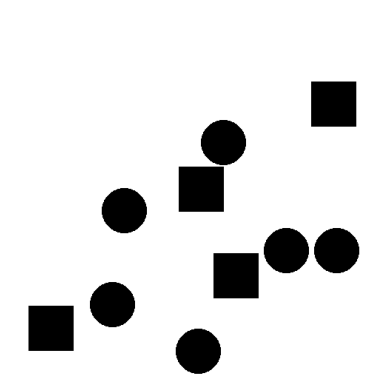

In [ ]:
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt  # Для отображения изображения

# Параметры изображения
IMAGE_SIZE = (500, 500)  # Размер изображения
CIRCLE_RADIUS = 30       # Радиус кругов
SQUARE_SIZE = 60         # Размер стороны квадрата
NUM_SHAPES = 10          # Общее количество фигур (кругов и квадратов)

# Создаем новое изображение
image = Image.new("1", IMAGE_SIZE, color=1)  # "1" означает черно-белый режим
draw = ImageDraw.Draw(image)

# Функция для проверки пересечения двух прямоугольников
def is_overlapping(rect1, rect2):
    """
    Проверяет, пересекаются ли два прямоугольника.
    rect1 и rect2 — кортежи с координатами (left, top, right, bottom).
    """
    return not (rect1[2] <= rect2[0] or  # rect1 справа от rect2
                rect1[0] >= rect2[2] or  # rect1 слева от rect2
                rect1[3] <= rect2[1] or  # rect1 ниже rect2
                rect1[1] >= rect2[3])    # rect1 выше rect2

# Функция для проверки, что новая фигура не пересекается с существующими
def is_valid_position(new_shape, existing_shapes):
    for shape in existing_shapes:
        if is_overlapping(new_shape, shape):
            return False
    return True

# Список для хранения границ фигур
existing_shapes = []

# Генерация фигур
for _ in range(NUM_SHAPES):
    is_circle = random.choice([True, False])  # Случайный выбор: круг или квадрат
    attempts = 0
    max_attempts = 1000  # Ограничение попыток размещения фигуры

    while attempts < max_attempts:
        # Случайные координаты центра фигуры
        x = random.randint(0, IMAGE_SIZE[0])
        y = random.randint(0, IMAGE_SIZE[1])

        if is_circle:
            # Определяем границы круга
            left = x - CIRCLE_RADIUS
            top = y - CIRCLE_RADIUS
            right = x + CIRCLE_RADIUS
            bottom = y + CIRCLE_RADIUS
            circle_bounds = (left, top, right, bottom)

            # Проверяем, что круг помещается в изображении и не пересекается
            if left >= 0 and top >= 0 and right < IMAGE_SIZE[0] and bottom < IMAGE_SIZE[1]:
                if is_valid_position(circle_bounds, existing_shapes):
                    draw.ellipse(circle_bounds, fill=0)  # Рисуем круг
                    existing_shapes.append(circle_bounds)
                    break
        else:
            # Определяем границы квадрата
            left = x - SQUARE_SIZE // 2
            top = y - SQUARE_SIZE // 2
            right = x + SQUARE_SIZE // 2
            bottom = y + SQUARE_SIZE // 2
            square_bounds = (left, top, right, bottom)

            # Проверяем, что квадрат помещается в изображении и не пересекается
            if left >= 0 and top >= 0 and right < IMAGE_SIZE[0] and bottom < IMAGE_SIZE[1]:
                if is_valid_position(square_bounds, existing_shapes):
                    draw.rectangle(square_bounds, fill=0)  # Рисуем квадрат
                    existing_shapes.append(square_bounds)
                    break

        attempts += 1

# Сохраняем изображение
image.save("shapes_image.png")
print("Изображение сохранено как 'shapes_image.png'")

# Отображаем изображение с помощью matplotlib
plt.imshow(image, cmap='gray')  # Используем серую цветовую карту для черно-белого изображения
plt.axis('off')  # Отключаем оси
plt.show()

1. На черно-белом изображении поставлены непересекающиеся, несопрекасающиеся и целые круги и квадраты заданного размера. Посчитайте число целых кругов и квадратов, не используя библиотеку cv2 или подобную.

In [ ]:
from PIL import Image
import numpy as np
from collections import deque

# Загрузка изображения
image = Image.open("shapes_image.png").convert("1")  # Черно-белое изображение
pixels = np.array(image)  # Преобразуем в массив NumPy

# Параметры изображения
rows, cols = pixels.shape

# Направления для обхода соседей (4-связность)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Функция для поиска связной области
def find_connected_component(start_row, start_col, visited):
    queue = deque([(start_row, start_col)])
    visited[start_row][start_col] = True
    component = []

    while queue:
        row, col = queue.popleft()
        component.append((row, col))

        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < rows and 0 <= new_col < cols:
                if not visited[new_row][new_col] and pixels[new_row][new_col] == 0:
                    visited[new_row][new_col] = True
                    queue.append((new_row, new_col))

    return component

# Функция для классификации формы
def classify_shape(component):
    min_row = min(row for row, col in component)
    max_row = max(row for row, col in component)
    min_col = min(col for row, col in component)
    max_col = max(col for row, col in component)

    width = max_col - min_col + 1
    height = max_row - min_row + 1

    # Площадь ограничивающего прямоугольника
    bounding_box_area = width * height

    # Количество черных пикселей внутри связной области
    filled_area = len(component)

    # Отношение заполненной площади к площади ограничивающего прямоугольника
    fill_ratio = filled_area / bounding_box_area

    # Классификация по коэффициенту заполнения
    if abs(width - height) <= 2:  # Допустимая погрешность для ширины и высоты
        if fill_ratio > 0.9:  # Близко к 1 — это квадрат
            return "square"
        elif fill_ratio > 0.6:  # Примерно 0.785 — это круг
            return "circle"
    return None

# Поиск всех фигур
visited = np.zeros_like(pixels, dtype=bool)
circle_count = 0
square_count = 0

for row in range(rows):
    for col in range(cols):
        if pixels[row][col] == 0 and not visited[row][col]:  # Нашли черный пиксель
            component = find_connected_component(row, col, visited)
            shape_type = classify_shape(component)
            if shape_type == "circle":
                circle_count += 1
            elif shape_type == "square":
                square_count += 1

# Вывод результатов
print(f"Количество кругов: {circle_count}")
print(f"Количество квадратов: {square_count}")

Количество кругов: 6
Количество квадратов: 4


Код для генерации цветного изображания с кругами и квадратами.

Изображение сохранено как 'color_shapes_image.png'


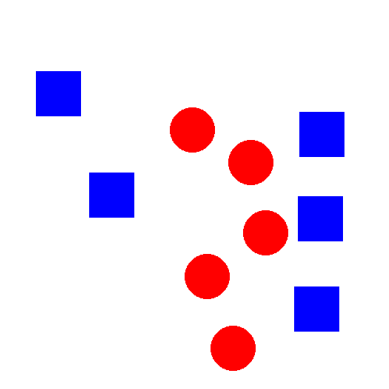

In [ ]:
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt

# Параметры изображения
IMAGE_SIZE = (500, 500)  # Размер изображения
CIRCLE_RADIUS = 30       # Радиус кругов
SQUARE_SIZE = 60         # Размер стороны квадрата
NUM_SHAPES = 10          # Общее количество фигур (кругов и квадратов)

# Цвета для фигур
CIRCLE_COLOR = (255, 0, 0)  # Красный
SQUARE_COLOR = (0, 0, 255)  # Синий
BACKGROUND_COLOR = (255, 255, 255)  # Белый фон

# Создаем новое изображение
image = Image.new("RGB", IMAGE_SIZE, color=BACKGROUND_COLOR)
draw = ImageDraw.Draw(image)

# Функция для проверки пересечения двух прямоугольников
def is_overlapping(rect1, rect2):
    return not (rect1[2] <= rect2[0] or  # rect1 справа от rect2
                rect1[0] >= rect2[2] or  # rect1 слева от rect2
                rect1[3] <= rect2[1] or  # rect1 ниже rect2
                rect1[1] >= rect2[3])    # rect1 выше rect2

# Функция для проверки, что новая фигура не пересекается с существующими
def is_valid_position(new_shape, existing_shapes):
    for shape in existing_shapes:
        if is_overlapping(new_shape, shape):
            return False
    return True

# Список для хранения границ фигур
existing_shapes = []

# Генерация фигур
for _ in range(NUM_SHAPES):
    is_circle = random.choice([True, False])  # Случайный выбор: круг или квадрат
    attempts = 0
    max_attempts = 1000  # Ограничение попыток размещения фигуры

    while attempts < max_attempts:
        # Случайные координаты центра фигуры
        x = random.randint(0, IMAGE_SIZE[0])
        y = random.randint(0, IMAGE_SIZE[1])

        if is_circle:
            # Определяем границы круга
            left = x - CIRCLE_RADIUS
            top = y - CIRCLE_RADIUS
            right = x + CIRCLE_RADIUS
            bottom = y + CIRCLE_RADIUS
            circle_bounds = (left, top, right, bottom)

            # Проверяем, что круг помещается в изображении и не пересекается
            if left >= 0 and top >= 0 and right < IMAGE_SIZE[0] and bottom < IMAGE_SIZE[1]:
                if is_valid_position(circle_bounds, existing_shapes):
                    draw.ellipse(circle_bounds, fill=CIRCLE_COLOR)  # Рисуем круг
                    existing_shapes.append(circle_bounds)
                    break
        else:
            # Определяем границы квадрата
            left = x - SQUARE_SIZE // 2
            top = y - SQUARE_SIZE // 2
            right = x + SQUARE_SIZE // 2
            bottom = y + SQUARE_SIZE // 2
            square_bounds = (left, top, right, bottom)

            # Проверяем, что квадрат помещается в изображении и не пересекается
            if left >= 0 and top >= 0 and right < IMAGE_SIZE[0] and bottom < IMAGE_SIZE[1]:
                if is_valid_position(square_bounds, existing_shapes):
                    draw.rectangle(square_bounds, fill=SQUARE_COLOR)  # Рисуем квадрат
                    existing_shapes.append(square_bounds)
                    break

        attempts += 1

# Сохраняем изображение
image.save("color_shapes_image.png")
print("Изображение сохранено как 'color_shapes_image.png'")

# Отображаем изображение с помощью matplotlib
plt.imshow(image)
plt.axis('off')  # Отключаем оси
plt.show()

2. Выполните п.1 для цветного изображения, считая, что круги и квадраты имеют заданный цвет.

In [ ]:
from PIL import Image
import numpy as np
from collections import deque

# Загрузка изображения
image = Image.open("color_shapes_image.png").convert("RGB")  # Цветное изображение
pixels = np.array(image)  # Преобразуем в массив NumPy

# Параметры изображения
rows, cols, _ = pixels.shape

# Цвета для кругов и квадратов (в формате RGB)
CIRCLE_COLOR = (255, 0, 0)  # Красный
SQUARE_COLOR = (0, 0, 255)  # Синий

# Направления для обхода соседей (4-связность)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Функция для поиска связной области заданного цвета
def find_connected_component(start_row, start_col, visited, target_color):
    queue = deque([(start_row, start_col)])
    visited[start_row][start_col] = True
    component = []

    while queue:
        row, col = queue.popleft()
        component.append((row, col))

        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < rows and 0 <= new_col < cols:
                if not visited[new_row][new_col] and tuple(pixels[new_row][new_col]) == target_color:
                    visited[new_row][new_col] = True
                    queue.append((new_row, new_col))

    return component

# Функция для классификации формы
def classify_shape(component):
    min_row = min(row for row, col in component)
    max_row = max(row for row, col in component)
    min_col = min(col for row, col in component)
    max_col = max(col for row, col in component)

    width = max_col - min_col + 1
    height = max_row - min_row + 1

    # Площадь ограничивающего прямоугольника
    bounding_box_area = width * height

    # Количество пикселей внутри связной области
    filled_area = len(component)

    # Отношение заполненной площади к площади ограничивающего прямоугольника
    fill_ratio = filled_area / bounding_box_area

    # Классификация по коэффициенту заполнения
    if abs(width - height) <= 2:  # Допустимая погрешность для ширины и высоты
        if fill_ratio > 0.9:  # Близко к 1 — это квадрат
            return "square"
        elif fill_ratio > 0.6:  # Примерно 0.785 — это круг
            return "circle"
    return None

# Поиск всех фигур
visited = np.zeros((rows, cols), dtype=bool)
circle_count = 0
square_count = 0

for row in range(rows):
    for col in range(cols):
        # Проверяем, является ли пиксель частью круга (красный цвет)
        if tuple(pixels[row][col]) == CIRCLE_COLOR and not visited[row][col]:
            component = find_connected_component(row, col, visited, CIRCLE_COLOR)
            shape_type = classify_shape(component)
            if shape_type == "circle":
                circle_count += 1

        # Проверяем, является ли пиксель частью квадрата (синий цвет)
        elif tuple(pixels[row][col]) == SQUARE_COLOR and not visited[row][col]:
            component = find_connected_component(row, col, visited, SQUARE_COLOR)
            shape_type = classify_shape(component)
            if shape_type == "square":
                square_count += 1

# Вывод результатов
print(f"Количество кругов: {circle_count}")
print(f"Количество квадратов: {square_count}")

Количество кругов: 5
Количество квадратов: 5


3. Возьмите изображение, которое содержит объекты и маркеры ARUCO. Сделайте из него 4 изображения с другими параметрами. Постройте график зависимости числа выделенных контуров на изображении от величины порогового уровня. Влияет ли качество изображения на это число?

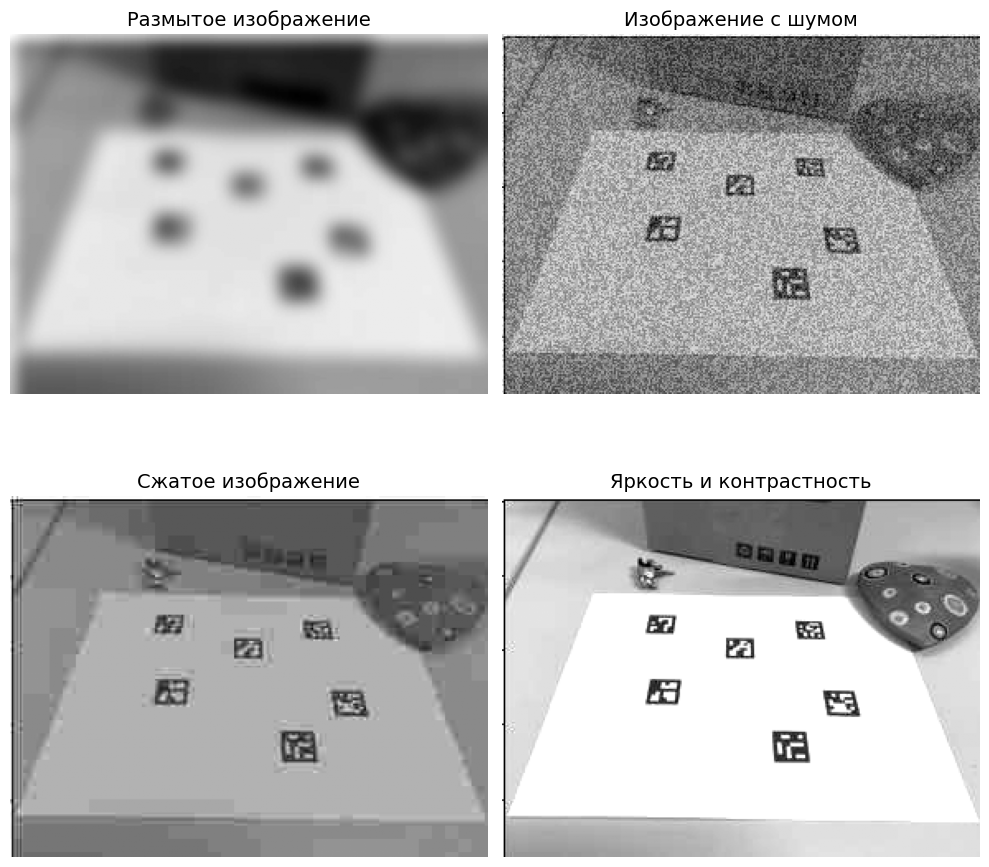

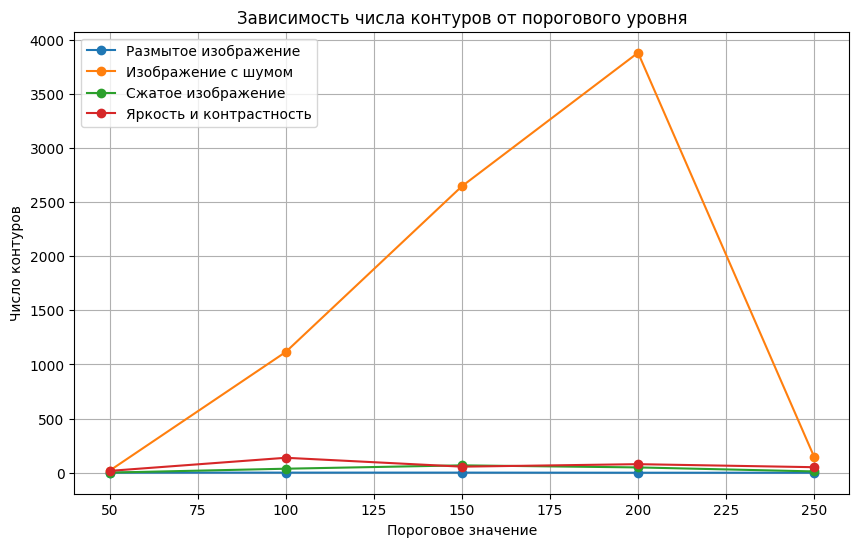

In [23]:
from PIL import Image, ImageFilter
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

# Загрузка исходного изображения
image = Image.open("aruco.jpg")

# Преобразование в градации серого, если изображение цветное
def to_grayscale(image):
    if image.mode != "L":  # Если изображение не в градациях серого
        return image.convert("L")
    return image

image = to_grayscale(image)

# 1. Размытие (Blur)
blurred_image = image.filter(ImageFilter.GaussianBlur(radius=5))  # Радиус размытия

# 2. Добавление шума
def add_noise(image, noise_factor=50):
    pixels = np.array(image)
    noise = np.random.randint(-noise_factor, noise_factor, pixels.shape, dtype=np.int16)
    noisy_pixels = np.clip(pixels.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_pixels)

noisy_image = add_noise(image)

# 3. JPEG-компрессия (с потерями)
def apply_jpeg_compression(image, quality=10):
    compressed_path = "compressed_image.jpg"
    image.save(compressed_path, format="JPEG", quality=quality)
    return Image.open(compressed_path)

compressed_image = apply_jpeg_compression(image, quality=10)  # Низкое качество

# 4. Изменение яркости и контрастности
def adjust_brightness_contrast(image, brightness_factor=1.5, contrast_factor=1.5):
    pixels = np.array(image).astype(np.float32)
    pixels = (pixels * brightness_factor - 128 * (brightness_factor - 1)) * contrast_factor
    pixels = np.clip(pixels, 0, 255).astype(np.uint8)
    return Image.fromarray(pixels)

adjusted_image = adjust_brightness_contrast(image)

# Функция для бинаризации изображения
def binarize(image, threshold):
    pixels = np.array(image)  # Преобразуем изображение в массив
    return (pixels > threshold).astype(np.uint8) * 255  # Бинаризация

# Функция для поиска связной области
def find_connected_component(start_row, start_col, visited, binary_image):
    rows, cols = binary_image.shape[:2]
    queue = deque([(start_row, start_col)])
    visited[start_row][start_col] = True

    while queue:
        row, col = queue.popleft()

        # Проверяем соседние пиксели
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < rows and 0 <= new_col < cols:
                if not visited[new_row][new_col] and binary_image[new_row][new_col] == 255:
                    visited[new_row][new_col] = True
                    queue.append((new_row, new_col))

# Функция для подсчета контуров
def count_contours(image, thresholds):
    contour_counts = []
    for threshold in thresholds:
        binary_image = binarize(image, threshold)
        rows, cols = binary_image.shape[:2]
        visited = np.zeros_like(binary_image, dtype=bool)
        num_contours = 0

        for row in range(rows):
            for col in range(cols):
                if binary_image[row][col] == 255 and not visited[row][col]:
                    find_connected_component(row, col, visited, binary_image)
                    num_contours += 1

        contour_counts.append(num_contours)
    return contour_counts

# Пороговые значения для анализа
thresholds = list(range(50, 251, 50))  # [50, 100, 150, 200]

# Подсчет контуров для каждого изображения
images = [blurred_image, noisy_image, compressed_image, adjusted_image]
titles = ["Размытое изображение", "Изображение с шумом", "Сжатое изображение", "Яркость и контрастность"]
contour_data = []

for img in images:
    contour_data.append(count_contours(img, thresholds))

# Отображение изображений на одном экране
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Создаем сетку 2x2
axes = axes.flatten()  # Преобразуем массив осей в одномерный

# Отображение каждого изображения
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')  # Отображаем в градациях серого
    ax.set_title(titles[i], fontsize=14)
    ax.axis('off')  # Отключаем оси

plt.tight_layout()  # Улучшаем расположение элементов
plt.show()

# Построение графика зависимости числа контуров от порогового уровня
plt.figure(figsize=(10, 6))
for i, counts in enumerate(contour_data):
    plt.plot(thresholds, counts, marker='o', label=titles[i])

# Настройка графика
plt.title("Зависимость числа контуров от порогового уровня")
plt.xlabel("Пороговое значение")
plt.ylabel("Число контуров")
plt.legend()
plt.grid(True)
plt.show()

4. Для изображений п.3 постройте график зависимости числа выделенных маркеров ARUCO от пороговой площади для фильтрации контуров.

Подсчитано маркеров для Размытое изображение: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Подсчитано маркеров для Изображение с шумом: [10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Подсчитано маркеров для Сжатое изображение: [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Подсчитано маркеров для Яркость и контрастность: [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


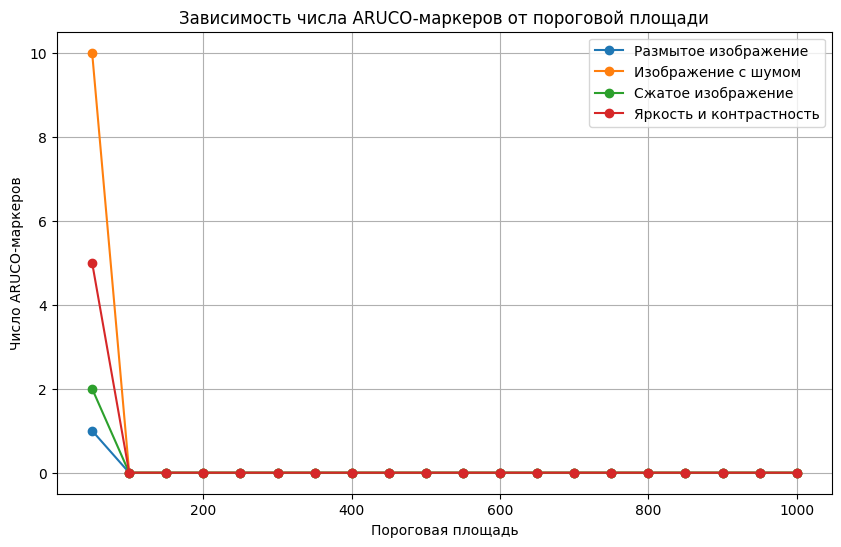

In [25]:
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Загрузка исходного изображения
image = Image.open("aruco.jpg")

# Преобразование в градации серого, если изображение цветное
def to_grayscale(image):
    if image.mode != "L":  # Если изображение не в градациях серого
        return image.convert("L")
    return image

image = to_grayscale(image)

# 1. Размытие (Blur)
blurred_image = image.filter(ImageFilter.GaussianBlur(radius=5))  # Радиус размытия

# 2. Добавление шума
def add_noise(image, noise_factor=50):
    pixels = np.array(image)
    noise = np.random.randint(-noise_factor, noise_factor, pixels.shape, dtype=np.int16)
    noisy_pixels = np.clip(pixels.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_pixels)

noisy_image = add_noise(image)

# 3. JPEG-компрессия (с потерями)
def apply_jpeg_compression(image, quality=10):
    compressed_path = "compressed_image.jpg"
    image.save(compressed_path, format="JPEG", quality=quality)
    return Image.open(compressed_path)

compressed_image = apply_jpeg_compression(image, quality=10)  # Низкое качество

# 4. Изменение яркости и контрастности
def adjust_brightness_contrast(image, brightness_factor=1.5, contrast_factor=1.5):
    pixels = np.array(image).astype(np.float32)
    pixels = (pixels * brightness_factor - 128 * (brightness_factor - 1)) * contrast_factor
    pixels = np.clip(pixels, 0, 255).astype(np.uint8)
    return Image.fromarray(pixels)

adjusted_image = adjust_brightness_contrast(image)

# Функция для бинаризации изображения
def binarize(image, threshold=128):
    pixels = np.array(image)  # Преобразуем изображение в массив
    return (pixels > threshold).astype(np.uint8) * 255  # Бинаризация

# Функция для поиска связной области
def find_connected_component(start_row, start_col, visited, binary_image):
    rows, cols = binary_image.shape[:2]
    queue = deque([(start_row, start_col)])
    visited[start_row][start_col] = True
    component = []

    while queue:
        row, col = queue.popleft()
        component.append((row, col))

        # Проверяем соседние пиксели
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < rows and 0 <= new_col < cols:
                if not visited[new_row][new_col] and binary_image[new_row][new_col] == 255:
                    visited[new_row][new_col] = True
                    queue.append((new_row, new_col))

    return component

# Функция для подсчета ARUCO-маркеров
def count_aruco_markers(image, area_thresholds):
    binary_image = binarize(image, threshold=128)  # Бинаризация с фиксированным порогом
    rows, cols = binary_image.shape[:2]
    visited = np.zeros_like(binary_image, dtype=bool)
    marker_counts = []

    for area_threshold in area_thresholds:
        num_markers = 0

        for row in range(rows):
            for col in range(cols):
                if binary_image[row][col] == 255 and not visited[row][col]:
                    component = find_connected_component(row, col, visited, binary_image)
                    area = len(component)

                    # Проверяем площадь и форму (примерно квадратная)
                    if area > area_threshold:
                        min_row = min(r for r, c in component)
                        max_row = max(r for r, c in component)
                        min_col = min(c for r, c in component)
                        max_col = max(c for r, c in component)

                        width = max_col - min_col + 1
                        height = max_row - min_row + 1

                        # Смягчаем условие для формы
                        if abs(width - height) <= 10:  # Увеличиваем допустимую погрешность
                            num_markers += 1

        marker_counts.append(num_markers)

    return marker_counts

# Пороговые значения площади для анализа
area_thresholds = list(range(50, 1001, 50))  # [50, 100, ..., 1000]

# Подсчет ARUCO-маркеров для каждого изображения
images = [blurred_image, noisy_image, compressed_image, adjusted_image]
titles = ["Размытое изображение", "Изображение с шумом", "Сжатое изображение", "Яркость и контрастность"]
marker_data = []

for img in images:
    marker_counts = count_aruco_markers(img, area_thresholds)
    marker_data.append(marker_counts)
    print(f"Подсчитано маркеров для {titles[len(marker_data) - 1]}: {marker_counts}")

# Построение графика
plt.figure(figsize=(10, 6))
for i, counts in enumerate(marker_data):
    plt.plot(area_thresholds, counts, marker='o', label=titles[i])

# Настройка графика
plt.title("Зависимость числа ARUCO-маркеров от пороговой площади")
plt.xlabel("Пороговая площадь")
plt.ylabel("Число ARUCO-маркеров")
plt.legend()
plt.grid(True)
plt.show()

5. Выделите все маркеры на каждом изображении.

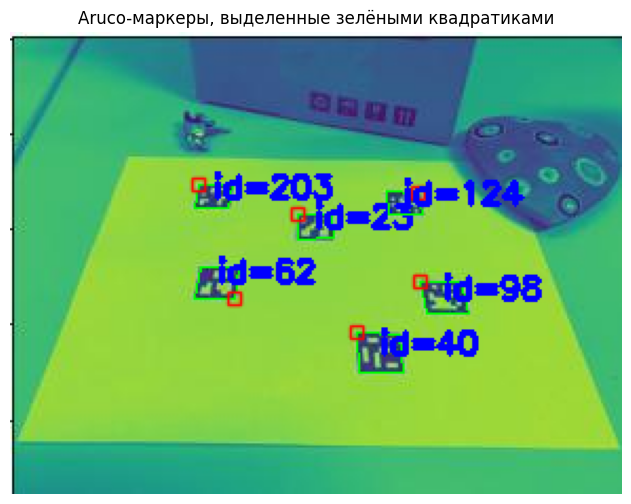

In [34]:
import cv2
import matplotlib.pyplot as plt

png_path = 'aruco.jpg'
img_color = cv2.imread(png_path)
if img_color is None:
    raise Exception("Не удалось загрузить изображение")

# 1. Получаем словарь маркеров
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_1000)

# 2. Создаём детектор
detector = cv2.aruco.ArucoDetector(dictionary)

# 3. Детектируем маркеры
corners, ids, rejected = detector.detectMarkers(img_color)

# 4. Если маркеры найдены, обводим их зелёными квадратиками
if ids is not None and len(ids) > 0:
    cv2.aruco.drawDetectedMarkers(img_color, corners, ids, borderColor=(0, 255, 0))
else:
    print("Маркеры не найдены.")

# 5. Отображаем результат
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Аruco-маркеры, выделенные зелёными квадратиками")
plt.axis("off")
plt.show()

Изображение с выделенными маркерами сохранено как 'highlighted_markers_clean.jpg'


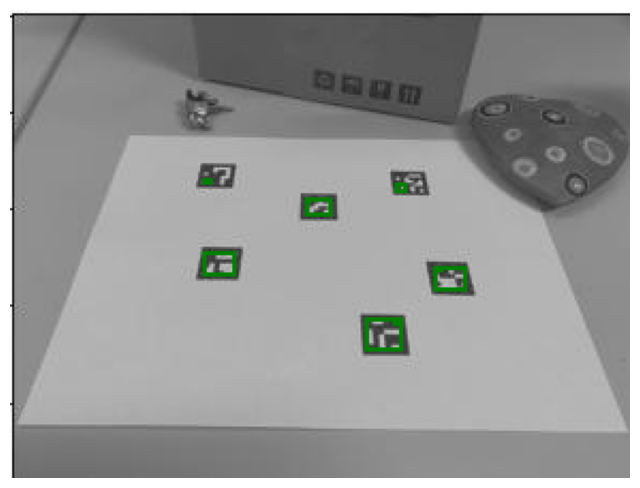

In [115]:
from PIL import Image, ImageDraw
import numpy as np
from collections import deque

# Загрузка исходного изображения
image = Image.open("aruco.jpg")

# Преобразование в градации серого, если изображение цветное
def to_grayscale(image):
    if image.mode != "L":  # Если изображение не в градациях серого
        return image.convert("L")
    return image

gray_image = to_grayscale(image)

# Адаптивная бинаризация
def adaptive_binarize(image, block_size=19, offset=55):
    pixels = np.array(image)
    thresholded = np.zeros_like(pixels, dtype=np.uint8)
    rows, cols = pixels.shape

    for row in range(rows):
        for col in range(cols):
            # Локальная область для расчета порога
            x_min = max(0, row - block_size // 2)
            x_max = min(rows, row + block_size // 2 + 1)
            y_min = max(0, col - block_size // 2)
            y_max = min(cols, col + block_size // 2 + 1)
            local_area = pixels[x_min:x_max, y_min:y_max]

            # Пороговое значение
            threshold = local_area.mean() - offset
            thresholded[row, col] = 255 if pixels[row][col] > threshold else 0

    return thresholded

# Функция для поиска связной области
def find_connected_component(start_row, start_col, visited, binary_image):
    rows, cols = binary_image.shape[:2]
    queue = deque([(start_row, start_col)])
    visited[start_row][start_col] = True
    component = []

    while queue:
        row, col = queue.popleft()
        component.append((row, col))

        # Проверяем соседние пиксели
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < rows and 0 <= new_col < cols:
                if not visited[new_row][new_col] and binary_image[new_row][new_col] == 255:
                    visited[new_row][new_col] = True
                    queue.append((new_row, new_col))

    return component

# Функция для выделения ARUCO-маркера
def detect_aruco_marker(image, area_threshold=5, shape_tolerance=5):
    binary_image = adaptive_binarize(image)  # Адаптивная бинаризация
    rows, cols = binary_image.shape[:2]
    visited = np.zeros_like(binary_image, dtype=bool)
    markers = []

    for row in range(rows):
        for col in range(cols):
            if binary_image[row][col] == 255 and not visited[row][col]:
                component = find_connected_component(row, col, visited, binary_image)
                area = len(component)

                # Проверяем площадь и форму (примерно квадратная)
                if area > area_threshold:
                    min_row = min(r for r, c in component)
                    max_row = max(r for r, c in component)
                    min_col = min(c for r, c in component)
                    max_col = max(c for r, c in component)

                    width = max_col - min_col + 1
                    height = max_row - min_row + 1

                    # Проверяем соотношение сторон
                    if abs(width - height) <= shape_tolerance:  # Допустимая погрешность для квадрата
                        markers.append((min_col, min_row, max_col, max_row))  # Сохраняем координаты границ

    return markers

# Выделяем ARUCO-маркеры
markers = detect_aruco_marker(gray_image)

# Рисуем прямоугольники вокруг найденных маркеров
rgb_image = gray_image.convert("RGB")
draw = ImageDraw.Draw(rgb_image)

for marker in markers:
    draw.rectangle(marker, outline="green", width=2)  # Рисуем зеленый контур

# Сохраняем результат
rgb_image.save("highlighted_markers_clean.jpg")
print("Изображение с выделенными маркерами сохранено как 'highlighted_markers_clean.jpg'")

# Отображаем изображение
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

6. Возьмите 5 цветных изображений одинакового размера с разными параметрами. Исследуйте влияние количества выделяемых ключевых точек и дескрипторов на результат сопоставления изображения. Оцените минимальное расстояние.

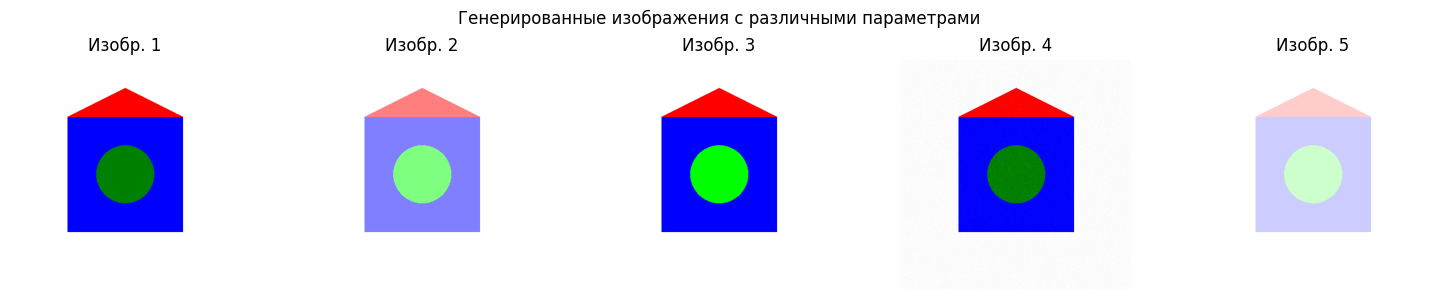

In [129]:
from PIL import Image, ImageDraw
import numpy as np

# Размер изображения
IMAGE_SIZE = (400, 400)

# Создание базового изображения с геометрическими фигурами
def create_base_image():
    image = Image.new("RGB", IMAGE_SIZE, "white")
    draw = ImageDraw.Draw(image)

    # Рисуем квадраты и треугольники
    draw.rectangle([100, 100, 300, 300], fill="blue")  # Синий квадрат
    draw.polygon([(100, 100), (300, 100), (200, 50)], fill="red")  # Красный треугольник
    draw.ellipse([150, 150, 250, 250], fill="green")  # Зеленый круг

    return image

# Применение различных параметров к изображению
def apply_parameters(image, brightness=1.0, contrast=1.0, noise_level=0):
    pixels = np.array(image)

    # Изменение яркости и контрастности
    adjusted_pixels = np.clip(pixels * contrast + brightness * 255, 0, 255).astype(np.uint8)

    # Добавление шума
    if noise_level > 0:
        noise = np.random.randint(-noise_level, noise_level + 1, size=pixels.shape, dtype=np.int16)
        adjusted_pixels = np.clip(adjusted_pixels.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    return Image.fromarray(adjusted_pixels)

# Генерация 5 изображений с разными параметрами
base_image = create_base_image()
images = []

# Параметры для каждого изображения
parameters = [
    {"brightness": 0.0, "contrast": 1.0, "noise_level": 0},  # Нормальное изображение
    {"brightness": 0.5, "contrast": 1.0, "noise_level": 0},  # Уменьшенная яркость
    {"brightness": 0.0, "contrast": 2.5, "noise_level": 0},  # Увеличенная контрастность
    {"brightness": 0.0, "contrast": 1.0, "noise_level": 10},  # Шум
    {"brightness": 0.8, "contrast": 0.5, "noise_level": 0}   # Уменьшенная контрастность
]

for i, param in enumerate(parameters):
    modified_image = apply_parameters(base_image, **param)
    images.append(modified_image)
    modified_image.save(f"image_{i + 1}.png")

# Визуализация всех изображений
plt.figure(figsize=(15, 3))
for i, image in enumerate(images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Изобр. {i + 1}")
    plt.axis('off')

plt.suptitle("Генерированные изображения с различными параметрами")
plt.tight_layout()
plt.show()

<ipython-input-120-2e281c77bfe2>:28: RuntimeWarning: overflow encountered in scalar add
  if all(center > n + threshold for n in neighbors):


Количество ключевых точек на изображении: 11186
Количество ключевых точек на изображении: 13767
Количество ключевых точек на изображении: 11186
Количество ключевых точек на изображении: 13767
Количество ключевых точек на изображении: 11186


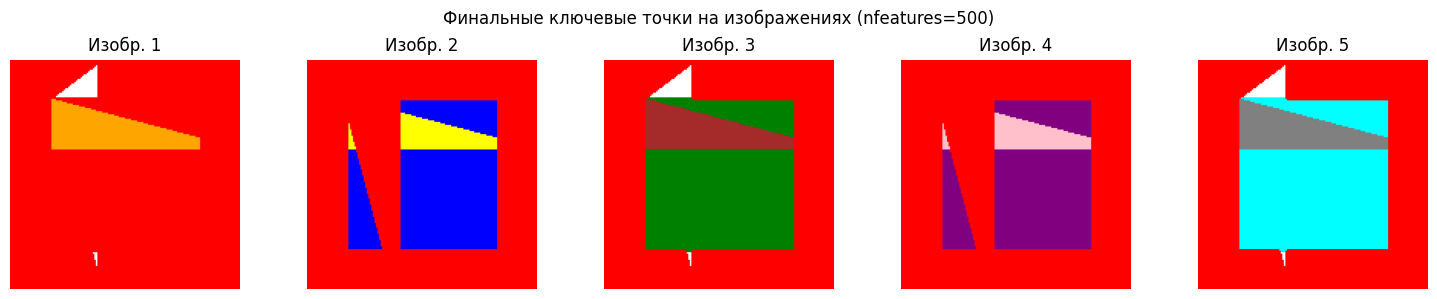

In [120]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

# Функция для загрузки изображения
def load_image(path):
    return Image.open(path)

# Функция для выделения ключевых точек (локальные максимумы яркости)
def detect_keypoints(image, threshold=50):
    img = image.convert("L")  # Преобразуем в градации серого
    pixels = np.array(img)
    rows, cols = pixels.shape
    keypoints = []

    # Ограничиваем значения пикселей, чтобы избежать переполнения
    pixels = np.clip(pixels, 0, 255)

    for row in range(1, rows - 1):
        for col in range(1, cols - 1):
            center = pixels[row, col]
            neighbors = [
                pixels[row - 1, col], pixels[row + 1, col],
                pixels[row, col - 1], pixels[row, col + 1]
            ]

            # Проверяем, является ли центральный пиксель локальным максимумом
            if all(center > n + threshold for n in neighbors):
                keypoints.append((row, col))

    print(f"Количество ключевых точек на изображении: {len(keypoints)}")
    return keypoints

# Функция для отрисовки ключевых точек на изображении
def draw_keypoints(image, keypoints, color="red"):
    draw = ImageDraw.Draw(image)
    for keypoint in keypoints:
        x, y = keypoint
        draw.ellipse((x - 2, y - 2, x + 2, y + 2), fill=color)  # Рисуем красную точку
    return image

# Путь к изображениям домиков
image_paths = [f"house_{i}.png" for i in range(1, 6)]

# Создаем сетку изображений
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, path in enumerate(image_paths):
    # Загружаем изображение
    image = load_image(path)

    # Выделяем ключевые точки
    keypoints = detect_keypoints(image, threshold=50)

    # Отрисовываем ключевые точки
    image_with_keypoints = draw_keypoints(image, keypoints)

    # Отображаем изображение
    axes[i].imshow(image_with_keypoints)
    axes[i].set_title(f"Изобр. {i + 1}")
    axes[i].axis('off')

plt.suptitle("Финальные ключевые точки на изображениях (nfeatures=500)")
plt.tight_layout()
plt.show()

7. Решите задачу сопоставления изображений с модифицированным изображением, но помимо задачи уменьшения размера рассмотрите задачу, в которой ключевые точки берутся из прямоугольника, ограниченного крайними ключевыми точками целевых изображений (маркеров).

8. Решите задачу сопоставления изображений, проанализировав параллельность линий, соединяющих ключевые точки на изображениях.

9. Наложите одно изображение меньшего размера на изображение большого размера.

10. Выполните п.3-9 для изображения/видео, получаемых с видеокамеры в режиме реального времени.